In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Time series
from datetime import datetime
import scipy.stats
import pylab
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

 # Error Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Models
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [0]:
# Use data from google drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Go to link, sign in, and paste in result

In [0]:
# Print a list of all files in a specified Drive folder
file_list = drive.ListFile({'q': "'1kE03N5LwmWDDsDescCPmlQxGsY7ZKEnT' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: Weekly_U.S._All_Grades_All_Formulations_Retail_Gasoline_Prices, id: 1cmGfdjaAd7RXYa_9S8RcraEDBA1fJKoKzB17KcaEo7Y
title: Weekly_U.S._All_Grades_All_Formulations_Retail_Gasoline_Prices.csv, id: 1pBHxMMMbUXZfFhNj5c2KqFq_dm4EkYOK
title: vehicles.csv, id: 12aa_5F_dECaFGjQR5KYZwToAqhHouUNi
title: carfullspecs.csv, id: 1Y9oQ0huvw3LYnbafa-AM7Ig5cOK95DkD


In [0]:
# Look up the specified file id and download it by name
downloaded = drive.CreateFile({'id':"1pBHxMMMbUXZfFhNj5c2KqFq_dm4EkYOK"})  
downloaded.GetContentFile('Weekly_U.S._All_Grades_All_Formulations_Retail_Gasoline_Prices.csv')       

## Load and explore data

In [0]:
# Weekly data
df_orig = pd.read_csv('Weekly_U.S._All_Grades_All_Formulations_Retail_Gasoline_Prices.csv'
          , header=4, names=['Date', 'Price'])
df = df_orig.copy()
df

,Date,Price
0,05/11/2020,1.941
1,05/4/2020,1.883
2,04/27/2020,1.870
3,04/20/2020,1.910
4,04/13/2020,1.951
...,...,...
1410,05/3/1993,1.086
1411,04/26/1993,1.086
1412,04/19/1993,1.079
1413,04/12/1993,1.079


In [0]:
df.describe()

,Price
count,1415.000000
mean,2.208776
std,0.893321
min,0.949000
25%,1.294000
50%,2.264000
75%,2.875000
max,4.165000


In [0]:
df.dtypes

Date      object
Price    float64
dtype: object

In [0]:
df.isnull().sum()

Date     0
Price    0
dtype: int64

In [0]:
df['Date'] = pd.to_datetime(df['Date'])

### Setting the index as time

In [0]:
df.set_index("Date", inplace=True)
df.head()

,Price
Date,
2020-05-11,1.941
2020-05-04,1.883
2020-04-27,1.870
2020-04-20,1.910
2020-04-13,1.951


In [0]:
# Setting the desired frequency
# df_w = df.asfreq('w')
# df_w

In [0]:
# Flip it so the index goes up with the date
df = df.iloc[::-1]

##Plotting

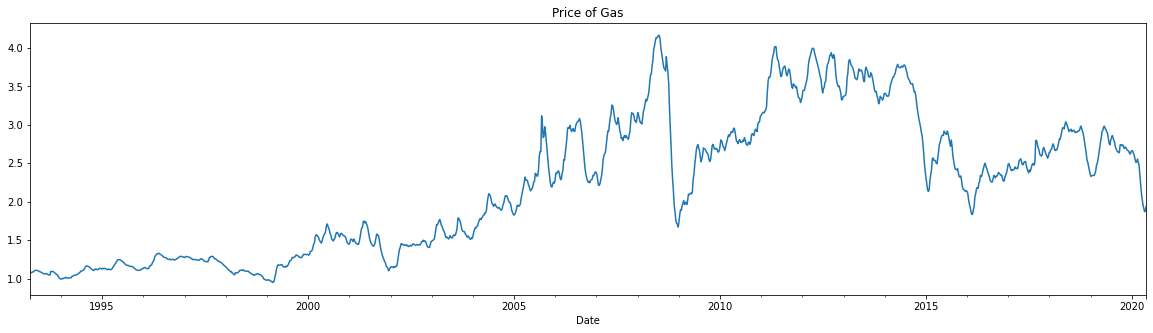

In [0]:
# Raw price vs time
df.Price.plot(figsize=(20,5), title='Price of Gas')

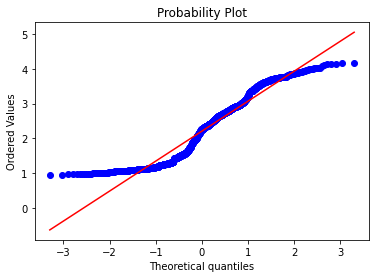

In [0]:
# Quantile-Quantile plot how the data fits a normal distribution
scipy.stats.probplot(df.Price, plot=pylab)
pylab.show()

The red line is what the data would be if it followed a normal dist.
The Theoretical quantiles are how many std devs away from the mean.

This shows that we cannot treat it as a normal dataset, it violates Gauss-Markov assumptions

### Train Val split

In [0]:
df.loc[:'2014']

,Price
Date,
1993-04-05,1.068
1993-04-12,1.079
1993-04-19,1.079
1993-04-26,1.086
1993-05-03,1.086
...,...
2014-12-01,2.864
2014-12-08,2.767
2014-12-15,2.643


In [0]:
# Make the last 5 years validation data
val = df.loc['2015':]
train = df.loc[:'2014']

val.shape, train.shape

((280, 1), (1135, 1))

In [0]:
# target = 'Price'
# X_feature = ['Date']

# X_train = train[X_feature]
# y_train = train[target]

# X_val = val[X_feature]
# y_val = val[target]



In [0]:
# Evaluator by Mikio Harman
# R^2 may not be appropriate for non-linear models
def scores(y_true, y_pred):
    
    """
    -This functions returns the MAE, MSE, RMSE, R2 scores
    -This function also takes the model name
    - Written by Mikio Harman
        
    """
    
    err_mae = mean_absolute_error(y_true, y_pred)
    err_mse = mean_squared_error(y_true, y_pred)
    err_rmse = np.sqrt(err_mse)
    err_r2 = r2_score(y_true, y_pred)
    
    print(f"MAE: {err_mae}\n")
    print(f"MSE: {err_mse}\n")
    print(f"RMSE: {err_rmse}\n")
    print(f"R^2: {err_r2}\n")
    
    return

# Models
Note that these models will predict gas prices over time, but in use we will multiply those prices by miles driven, and that will only need an average over the time span.

## Baseline

Mean guess for all prices

In [0]:
mean_gas_price = np.mean(train['Price'])
print(f"The mean gas from 04/05/1993 - 12/31/2014 is {mean_gas_price}\n")

y_true_base = val['Price']
y_pred_base = [mean_gas_price for x in range(len(val))]

scores(y_true_base, y_pred_base)

The mean gas from 04/05/1993 - 12/31/2014 is 2.125984140969161

MAE: 0.4399852485840167

MSE: 0.24920924183741353

RMSE: 0.4992086155480628

R^2: -2.3606377339614575



## Linear Regression

In [0]:
# I indexed the date in preparation for a time series analysis
# but here for an improper linear regression we just need an X that is a counter
ln_train = pd.DataFrame(range(0, 1135),columns=['date'])
ln_val = pd.DataFrame(range(1135, 1415),columns=['date'])

In [0]:
# values of interest is the number of days from the start
lr = LinearRegression()
lr.fit(ln_train, train['Price'])
y_pred_lr = lr.predict(ln_val)

scores(val['Price'], y_pred_lr)

MAE: 1.4955745565331942

MSE: 2.3205711910114033

RMSE: 1.5233421122687456

R^2: -30.29337841308743



as expected, a line would go way off on a time series like this

In [0]:
ln_plot_df = pd.DataFrame(y_pred_lr, val.index)

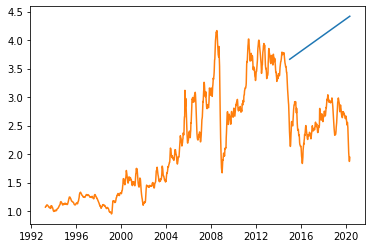

In [0]:
plt.plot(ln_plot_df)
plt.plot(df['Price'])

## [ARIMA](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations. **(p)**

I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.**(d)**

MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. **(q)**

*The parameters of the ARIMA model are defined as follows:*

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

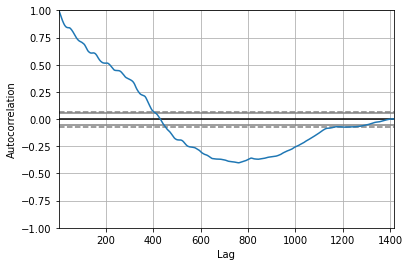

In [0]:
# Auto correlation plot
# Used to determine p, AR
autocorrelation_plot(df)
plt.show()

# shows significance for the first 400 lags. That sounds sus

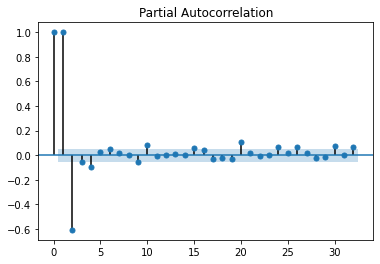

In [0]:
# partial Autocorrelation plot. 
# Use this to determine q, MA
plot_pacf(df)
plt.show()

An ARIMA model can be created using the statsmodels library as follows:

Define the model by calling ARIMA() and passing in the p, d, and q parameters.

The model is prepared on the training data by calling the fit() function.

Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

In [0]:
# Though the plots above suggested some p and q terms, I experimented with various
arima = ARIMA(train, order=(1,1,0))
model_fit = arima.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Price   No. Observations:                 1134
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2054.671
Method:                       css-mle   S.D. of innovations              0.040
Date:                Fri, 15 May 2020   AIC                          -4103.342
Time:                        17:17:22   BIC                          -4088.242
Sample:                    04-12-1993   HQIC                         -4097.638
                         - 12-29-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.003      0.393      0.694      -0.004       0.006
ar.L1.D.Price     0.5647      0.025     23.000      0.000       0.517       0.613
                                    Root

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


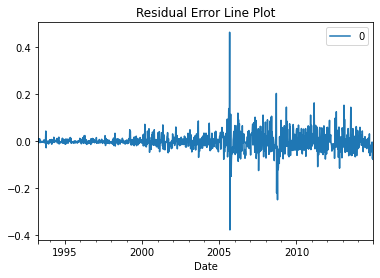

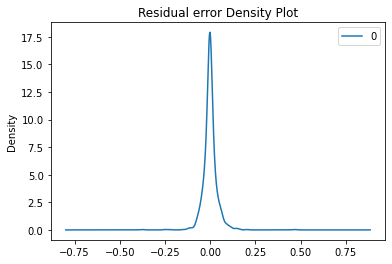

                 0
count  1134.000000
mean     -0.000005
std       0.039536
min      -0.377492
25%      -0.014537
50%      -0.001449
75%       0.012577
max       0.464104


In [0]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title='Residual Error Line Plot')
plt.show()
residuals.plot(kind='kde', title='Residual error Density Plot')
plt.show()
print(residuals.describe())

The residuals aren't exactly uniform as there is higher variance in the more recent years, but the distribution is very concentrated around 0

### Forecasts with ARIMA

In [0]:
# I think the  .predict method tells the difference between sequential prices
model_fit.predict(start=1, end=5)

1993-04-12    0.001059
1993-04-19    0.006673
1993-04-26    0.000461
1993-05-03    0.004414
1993-05-10    0.000461
Freq: W-MON, dtype: float64

In [0]:
# This is more what we are looking for
# Forecast by len(val)
y_pred_arima = model_fit.forecast(steps=len(val))[0]
print('ARIMA scores:'), scores(y_pred=y_pred_arima, y_true=val['Price'])

ARIMA scores:
MAE: 0.2316014269435614

MSE: 0.08617209359618845

RMSE: 0.29355083647673097

R^2: -0.16204835430117281



(None, None)

In [0]:
# Compare to baseline
print('Baseline scores:'), scores(y_true_base, y_pred_base)

Baseline score:
MAE: 0.4399852485840167

MSE: 0.24920924183741353

RMSE: 0.4992086155480628

R^2: -2.3606377339614575



(None, None)

In [0]:
df_pred_arima = pd.DataFrame(y_pred_arima, val.index)

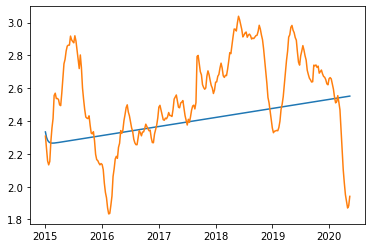

In [0]:
plt.plot(df_pred_arima)
plt.plot(val['Price'])

Successfully beat the baseline by over 10%